# Data Acquisition

In [1]:
import os
import shutil

import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

import librosa
import librosa.display

# !sudo apt-get install p7zip-full

## Definition of Control Variables

In [2]:
GDRIVE_DATA_DIR = "23-24_CE903-SU_team06/dataset/"

## Mount Google Drive

In [3]:
from google.colab import drive
contentPath = "/content/"
if not os.path.exists(contentPath + 'drive'):
  drive.mount( contentPath + 'drive')

Mounted at /content/drive


### Read Dataset and Get Frames

In [4]:
csv_files = [f"/content/drive/My Drive/{GDRIVE_DATA_DIR}audio_data_300_before_framing_16Khz.feather"]

In [5]:
df_from_save = pd.read_feather(csv_files[0])
df_from_save['key'] = df_from_save['index']
df_from_save.drop(columns=['index'], inplace=True)
df_from_save.set_index('key', inplace=True)
df_from_save.head(3)

,amp,amp_original,sf,sf_original,shape,shape_original,cough_start_end,label
key,,,,,,,,
b8cda82e-6549-4d43-aad9-8de9bcf8e0e9,"[1.6998944e-11, 1.6948607e-11, -3.3269082e-11,...","[6.2792744e-12, 1.3262988e-11, 2.1134771e-11, ...",16000,22050,[33600],[46305],None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
b9408db9-881b-4a95-ba6c-ac51602955a6,"[5.813955e-10, -7.632952e-10, -1.9169968e-09, ...","[5.454812e-10, -7.5795303e-10, -2.2023776e-09,...",16000,22050,[33600],[46305],None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
e9bf0a5a-ff96-480b-a54a-f647143e1d6f,"[6.08183e-09, 3.8103284e-08, 4.4398583e-08, 3....","[-7.584575e-09, -2.4847802e-09, 3.0562568e-08,...",16000,22050,[158400],[218295],"[[2.777657, 3.235886]]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Get Frames
- Variable: all_frames_from_save

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
GDRIVE_COMPONENT_DIR = f"/content/drive/My Drive/23-24_CE903-SU_team06/cough_segmentation/utils/"
print(os.listdir(GDRIVE_COMPONENT_DIR))

import sys
sys.path.append(GDRIVE_COMPONENT_DIR)

from framing import Framing
frame = Framing()

['__init__.py', 'framing.py', 'simple_ingestion.py', 'utils.py', '__pycache__', '.ipynb_checkpoints', 'sono_cross_val_zcr.py', 'train_with_zcr.py', 'feature_extraction_melspectogram.py', 'feature_extraction.py', 'sono_cross_val.py']


Frame size 1024, hop_length 512, count 82957
Frame size 2048, hop_length 1024, count 41222
Hop Length: 512


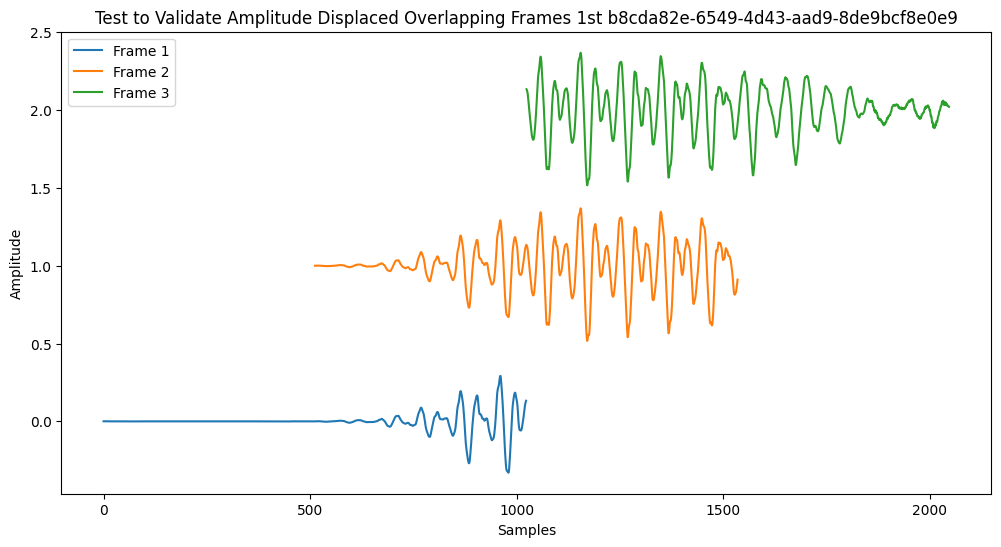

Hop Length: 512


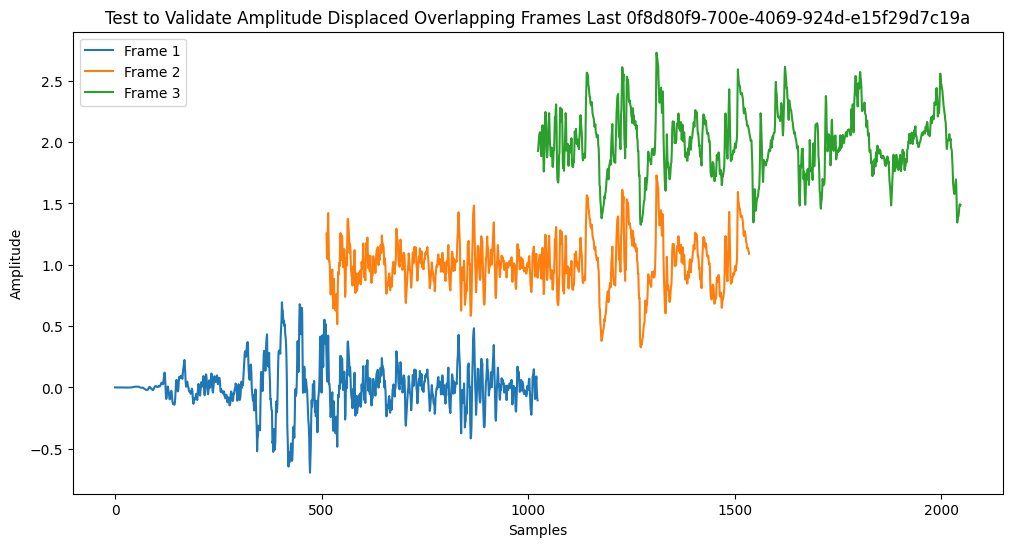

In [8]:
all_frames_from_save = frame.apply_framing(audio_df=df_from_save, frame_sizes=[1024,2048])
df_frame_from_save = all_frames_from_save[1024]
df_frame_from_save.head(3)

visual_set = {"1st":df_frame_from_save.head(1)["key"].values[0],"Last":df_frame_from_save.tail(1)["key"].values[0]}
frame.visualize_overlapping_frames(title='Test to Validate Amplitude Displaced Overlapping Frames', framed_df=df_frame_from_save, visual_set=visual_set)

# Feature Extraction

## Multiple Features
- ZCR
- RMS
- MFCC
- STFT

In [9]:
#pip install pandas librosa numpy joblib

In [10]:
import pandas as pd
import numpy as np
import librosa
from joblib import Parallel, delayed

# Function to extract features
def extract_features(row):
    y = row['amp']
    sr = row['sf']
    features = {}

    # Time-domain features
    features['zcr'] = np.mean(librosa.feature.zero_crossing_rate(y))
    features['rms'] = np.mean(librosa.feature.rms(y=y))

    # Mel-frequency cepstral coefficients (MFCC)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=1024)
    for i in range(mfcc.shape[0]):
        features[f'mfcc_{i+1}'] = np.mean(mfcc[i])

    return features


In [11]:
result_df = pd.read_feather(f"/content/drive/My Drive/{GDRIVE_DATA_DIR}fm.feather")

In [12]:
# Apply feature extraction using pd.apply
#features_df = df_frame_from_save.apply(extract_features, axis=1, result_type='expand')

# Concatenate original DataFrame with the features DataFrame
#result_df = pd.concat([df_frame_from_save, features_df], axis=1)

In [13]:
#result_df.to_feather(f"/content/drive/My Drive/{GDRIVE_DATA_DIR}fm.feather")

In [14]:
result_df.head(3)

,key,sf,start,end,max_amp,frame_index,amp,label,zcr,rms,...,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20
0,b8cda82e-6549-4d43-aad9-8de9bcf8e0e9,16000,0,1024,0.006137,0,"[1.6998944e-11, 1.6948607e-11, -3.3269082e-11,...",0,0.069824,0.001239,...,-3.747825,-2.129447,-8.984657,-2.875883,-5.484888,-2.900776,-5.278790,5.701860,-6.431706,-0.010407
1,b8cda82e-6549-4d43-aad9-8de9bcf8e0e9,16000,512,1536,0.023188,1,"[-0.00024980583, -0.00026363018, -0.0002713691...",0,0.018066,0.005495,...,-9.475435,-1.386078,-14.666367,-8.323562,-9.084435,-7.485100,-1.968719,5.180727,-3.391257,0.078789
2,b8cda82e-6549-4d43-aad9-8de9bcf8e0e9,16000,1024,2048,0.074459,2,"[-0.0018562947, -0.0023917924, -0.0028657983, ...",0,0.017090,0.016609,...,-7.582979,-1.790621,-14.074805,-10.279305,-6.322623,-10.850876,-4.282150,1.863045,-5.200188,-0.069243


In [15]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix, f1_score, ConfusionMatrixDisplay, roc_curve
import matplotlib.pyplot as plt

In [16]:
no_cough_class = df_from_save['cough_start_end'].isna()
no_cough_class

key
b8cda82e-6549-4d43-aad9-8de9bcf8e0e9     True
b9408db9-881b-4a95-ba6c-ac51602955a6     True
e9bf0a5a-ff96-480b-a54a-f647143e1d6f    False
e4729edf-12e5-4ba9-883e-1114c32b90f0    False
4c2840ed-fd4b-4a86-b976-5cc040d6ea4e    False
                                        ...  
48b287c0-5c2b-44ef-b469-3808b3b287ea    False
52f6838a-4033-4a71-84bb-81cbb4e64ab7    False
7a8bd218-252f-4d84-a035-0d3262efa825     True
9d539eb5-62de-4d5d-994b-866238ecd96e     True
0f8d80f9-700e-4069-924d-e15f29d7c19a    False
Name: cough_start_end, Length: 300, dtype: bool

In [17]:
from sklearn.model_selection import train_test_split

test_size = 0.2
# Perform train-test split
X_train_nocough, X_test_nocough = train_test_split(df_from_save[no_cough_class==True].index, test_size=test_size, random_state=42)

X_train_cough, X_test_cough = train_test_split(df_from_save[no_cough_class==False].index, test_size=test_size, random_state=42)

# Display the results
print("X_train_nocough:", X_train_nocough.shape)
print("X_test_nocough:", X_test_nocough.shape)
print("X_train_cough:", X_train_cough.shape)
print("X_test_cough:", X_test_cough.shape)

# merge train set (cough + nocough)
len(list(X_train_cough) + list(X_train_nocough))

X_train_nocough: (120,)
X_test_nocough: (30,)
X_train_cough: (120,)
X_test_cough: (30,)


240

## Cross val with 80% train set

In [18]:
# Get Train Set
result_df[ result_df['key'].isin( list(X_train_cough) + list(X_train_nocough) ) ].head(3)

,key,sf,start,end,max_amp,frame_index,amp,label,zcr,rms,...,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20
0,b8cda82e-6549-4d43-aad9-8de9bcf8e0e9,16000,0,1024,0.006137,0,"[1.6998944e-11, 1.6948607e-11, -3.3269082e-11,...",0,0.069824,0.001239,...,-3.747825,-2.129447,-8.984657,-2.875883,-5.484888,-2.900776,-5.278790,5.701860,-6.431706,-0.010407
1,b8cda82e-6549-4d43-aad9-8de9bcf8e0e9,16000,512,1536,0.023188,1,"[-0.00024980583, -0.00026363018, -0.0002713691...",0,0.018066,0.005495,...,-9.475435,-1.386078,-14.666367,-8.323562,-9.084435,-7.485100,-1.968719,5.180727,-3.391257,0.078789
2,b8cda82e-6549-4d43-aad9-8de9bcf8e0e9,16000,1024,2048,0.074459,2,"[-0.0018562947, -0.0023917924, -0.0028657983, ...",0,0.017090,0.016609,...,-7.582979,-1.790621,-14.074805,-10.279305,-6.322623,-10.850876,-4.282150,1.863045,-5.200188,-0.069243


Sono Cross Val Split
 StratifiedKFold(n_splits=5, random_state=6, shuffle=True) 	Total Audio Files: 240


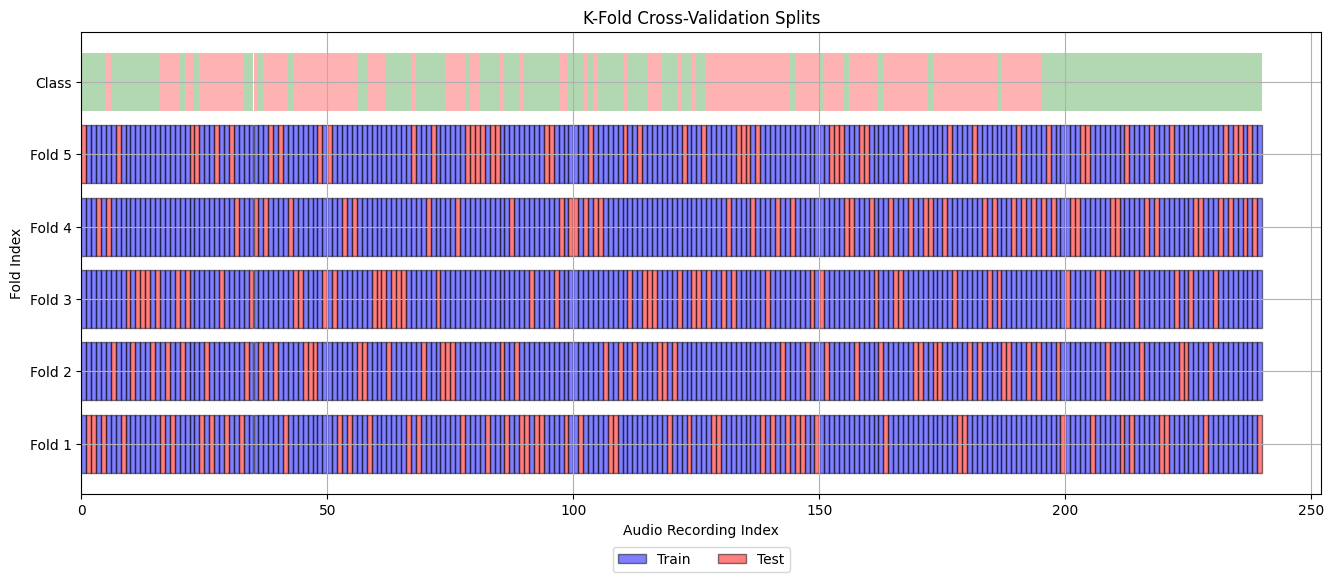

In [19]:
from sono_cross_val import CrossValSplit
cv_strat = CrossValSplit(df_single_frame=result_df[ result_df['key'].isin( list(X_train_cough) + list(X_train_nocough) ) ], non_cough_keys=X_train_nocough)
cv_strat_data = cv_strat.cross_val(stratified=True, shuffle=True, plot=True, show_fold_info=False)

In [20]:
from lightgbm import LGBMClassifier
!pip install xgboost
from xgboost import XGBClassifier

In [21]:
mods = [ 'logistic', 'lgbm', 'xgboost', 'svc', 'randomforest' ]

fold (Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       82947, 82948, 82949, 82950, 82951, 82952, 82953, 82954, 82955, 82956],
      dtype='int64', length=49073), Index([  993,   994,   995,   996,   997,   998,   999,  1000,  1001,  1002,
       ...
       81921, 81922, 81923, 81924, 81925, 81926, 81927, 81928, 81929, 81930],
      dtype='int64', length=14721))
Fitting 2 folds for each of 90 candidates, totalling 180 fits
Best Parameters: {'C': 50, 'max_iter': 100, 'solver': 'sag'}
Accuracy: 95.47%
Recall: 55.24%
Precision: 88.78%
F1: 68.10%
ROC AUC: 0.97


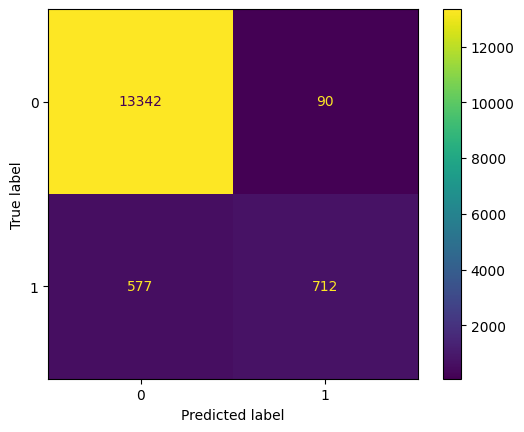

fold (Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       82229, 82230, 82231, 82232, 82233, 82234, 82235, 82236, 82237, 82238],
      dtype='int64', length=52133), Index([   64,    65,    66,    67,    68,    69,    70,    71,    72,    73,
       ...
       82947, 82948, 82949, 82950, 82951, 82952, 82953, 82954, 82955, 82956],
      dtype='int64', length=11661))
Fitting 2 folds for each of 90 candidates, totalling 180 fits
Best Parameters: {'C': 100, 'max_iter': 300, 'solver': 'saga'}
Accuracy: 93.37%
Recall: 48.62%
Precision: 76.11%
F1: 59.34%
ROC AUC: 0.94


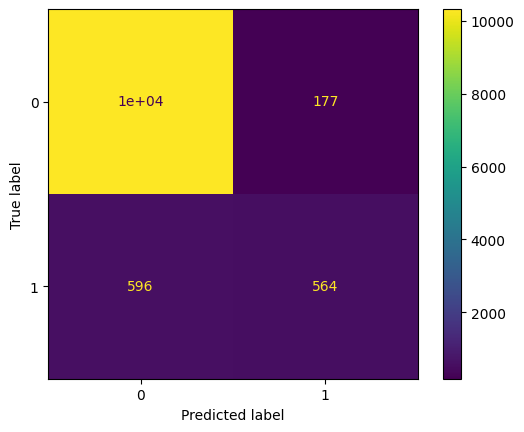

fold (Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       82947, 82948, 82949, 82950, 82951, 82952, 82953, 82954, 82955, 82956],
      dtype='int64', length=51420), Index([ 5215,  5216,  5217,  5218,  5219,  5220,  5221,  5222,  5223,  5224,
       ...
       81313, 81314, 81315, 81316, 81317, 81318, 81319, 81320, 81321, 81322],
      dtype='int64', length=12374))
Fitting 2 folds for each of 90 candidates, totalling 180 fits
Best Parameters: {'C': 100, 'max_iter': 500, 'solver': 'sag'}
Accuracy: 87.84%
Recall: 50.37%
Precision: 58.50%
F1: 54.13%
ROC AUC: 0.90


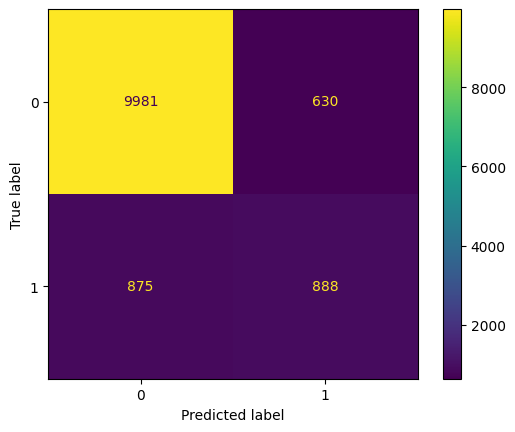

fold (Index([   64,    65,    66,    67,    68,    69,    70,    71,    72,    73,
       ...
       82947, 82948, 82949, 82950, 82951, 82952, 82953, 82954, 82955, 82956],
      dtype='int64', length=53492), Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       82229, 82230, 82231, 82232, 82233, 82234, 82235, 82236, 82237, 82238],
      dtype='int64', length=10302))
Fitting 2 folds for each of 90 candidates, totalling 180 fits
Best Parameters: {'C': 50, 'max_iter': 100, 'solver': 'saga'}
Accuracy: 89.23%
Recall: 57.11%
Precision: 60.26%
F1: 58.64%
ROC AUC: 0.91


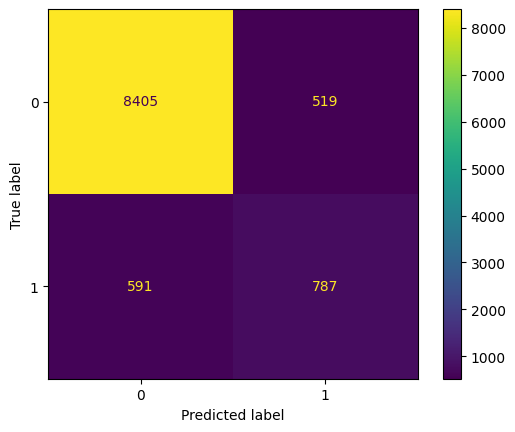

fold (Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       82947, 82948, 82949, 82950, 82951, 82952, 82953, 82954, 82955, 82956],
      dtype='int64', length=49058), Index([  436,   437,   438,   439,   440,   441,   442,   443,   444,   445,
       ...
       81619, 81620, 81621, 81622, 81623, 81624, 81625, 81626, 81627, 81628],
      dtype='int64', length=14736))
Fitting 2 folds for each of 90 candidates, totalling 180 fits
Best Parameters: {'C': 50, 'max_iter': 500, 'solver': 'sag'}
Accuracy: 94.50%
Recall: 48.16%
Precision: 75.33%
F1: 58.76%
ROC AUC: 0.92


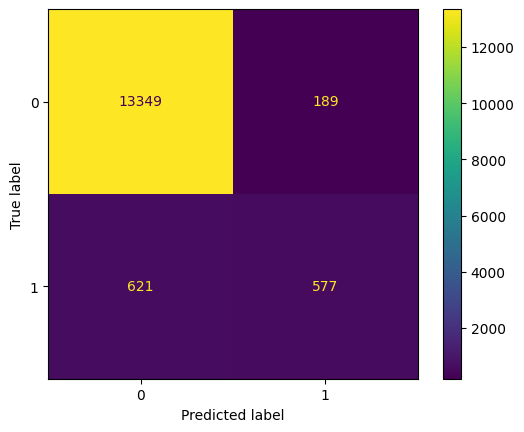

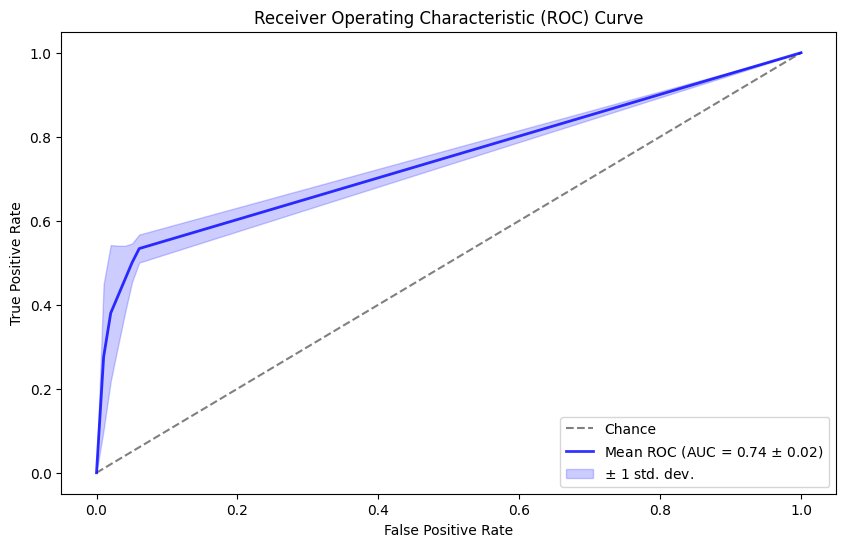

In [33]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
auc_roc_scores = []
auc_pr_scores = []
confusion_m = []

mod = 'svc'
mod = 'lgbm'
mod = 'randomforest'
mod = 'xgboost'
mod = 'logistic'

grids = ''
gs = True

# Define the parameter grid for Logistic Regression
param_grid = {}
param_grid["logistic"] = {
    'C': [0.1, 1, 10, 50, 100],    # Regularization strength
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],  # Solver algorithm
    'max_iter': [100, 300, 500]  # Maximum number of iterations
}
param_grid["randomforest"] = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}
# Define the parameter grid
param_grid["lgbm"] = {
    'num_leaves': [31, 50, 100],
    #'max_depth': [-1, 10, 20, 30],
    #'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    #'min_child_samples': [20, 50, 100],
    #'subsample': [0.6, 0.8, 1.0],
    #'colsample_bytree': [0.6, 0.8, 1.0],
    #'reg_alpha': [0, 0.1, 0.5],
    #'reg_lambda': [0, 0.1, 0.5],
    'boosting_type': ['gbdt', 'dart']
}
param_grid["xgboost"] = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.5, 1.0, 1.5]
}

# For plotting ROC curve
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []


if mod == 'svc':
  # Train an SVM classifier
  #svm = SVC(kernel='linear', probability=True)
  model = SVC(kernel='rbf')  #non-linearly seperable dataset
elif mod == 'lgbm':
  model = LGBMClassifier(n_estimators=60, random_state=42)
elif mod == 'randomforest':
  model = RandomForestClassifier(n_estimators=69, max_features='sqrt', min_samples_leaf=2, min_samples_split=2, class_weight='balanced_subsample', random_state=42)
elif mod == 'xgboost':
  #model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
  model = XGBClassifier(tree_method='gpu_hist', use_label_encoder=False, eval_metric='logloss')
else:
  # Initialize and train the Logistic Regression model
  if gs:
    model = LogisticRegression()
  else:
    model = LogisticRegression(C=10,max_iter=300, solver='sag')

for fold in cv_strat_data:
    X_train = result_df.loc[fold[0]].drop(columns=['amp', 'sf', 'label', 'start', 'end', 'max_amp', 'frame_index', 'key', 'mfcc_14', 'mfcc_16', 'mfcc_15', 'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20'])
    X_test = result_df.loc[fold[1]].drop(columns=['amp', 'sf', 'label', 'start', 'end', 'max_amp', 'frame_index', 'key', 'mfcc_14', 'mfcc_16', 'mfcc_15', 'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20'])

    y_train = result_df.loc[fold[0]]['label']
    y_test = result_df.loc[fold[1]]['label']

    print('fold', fold)

    # Standardize the feature matrix
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    if gs:
      grids = 'best_params'
      # Initialize GridSearchCV with Logistic Regression model and parameter grid
      grid_search = GridSearchCV(estimator=model, param_grid=param_grid[mod], cv=2, scoring='roc_auc', n_jobs=-1, verbose=1)

      # Perform grid search
      grid_search.fit(X_train_scaled, y_train)

      # Get the best estimator
      best_model = grid_search.best_estimator_

      # Make predictions on the test set
      y_pred = best_model.predict(X_test_scaled)
      y_pred_prob = best_model.predict_proba(X_test_scaled)[:, 1]
      #y_pred_prob = best_model.predict_proba(X_test)[:, 1]

      print(f'Best Parameters: {grid_search.best_params_}')
    else:
      model.fit(X_train_scaled, y_train)
      # Predict and evaluate the model
      y_pred = model.predict(X_test_scaled)
      y_pred_prob = model.predict(X_test_scaled)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print metrics
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"F1: {f1 * 100:.2f}%")
    print(f"ROC AUC: {roc_auc:.2f}")

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    auc_roc_scores.append(roc_auc)
    confusion_m.append(conf_matrix)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    auc = roc_auc_score(y_test, y_pred)
    aucs.append(auc)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot()
    plt.show()

if gs:
  model = best_model

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance')

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='blue', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [34]:
GDRIVE_DATA_DIR = "23-24_CE903-SU_team06/dataset/"
GDRIVE_MODEL_DIR = "23-24_CE903-SU_team06/saved_models/"

desired_path = f'/content/drive/My Drive/{GDRIVE_MODEL_DIR}'

In [37]:
# Construct the full file path
import joblib
model_path = f"/content/drive/My Drive/{GDRIVE_MODEL_DIR}{mod}{grids}_default.sav"

# Create the directory if it doesn't exist
os.makedirs(desired_path, exist_ok=True)
joblib.dump(model, model_path)

['/content/drive/My Drive/23-24_CE903-SU_team06/saved_models/logisticbest_params_default.sav']

In [38]:
def get_feature_importance(logistic_model, feature_names):
    """
    Get feature importance from a trained logistic regression model.

    Args:
    logistic_model (LogisticRegression): Trained logistic regression model.
    feature_names (list): List of feature names.

    Returns:
    pd.DataFrame: DataFrame containing features and their importance.
    """
    # Get the coefficients from the model
    coefficients = logistic_model.coef_[0]

    # Create a DataFrame to hold feature names and their corresponding coefficients
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': coefficients
    })

    # Sort the DataFrame by absolute value of the coefficients
    feature_importance = feature_importance.reindex(feature_importance.Importance.abs().sort_values(ascending=False).index)

    return feature_importance

dfr2 = result_df.drop(columns=['amp', 'sf', 'label', 'start', 'end', 'max_amp', 'frame_index', 'key', 'mfcc_14', 'mfcc_16', 'mfcc_15', 'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20'])
feature_importance = get_feature_importance(logistic_model=model, feature_names=dfr2.columns)
feature_importance

,Feature,Importance
2,mfcc_1,3.251888
6,mfcc_5,0.300842
10,mfcc_9,-0.256009
8,mfcc_7,-0.222484
1,rms,-0.205284
9,mfcc_8,-0.186227
5,mfcc_4,-0.168222
7,mfcc_6,0.143282
4,mfcc_3,-0.133715
12,mfcc_11,-0.077516


In [35]:
dfc = {
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1': f1_scores,
    'AUC ROC': auc_roc_scores,
    'Confusion Matrix':[i.tolist() for i in confusion_m]
}
dfr = pd.DataFrame(dfc)
dfr.to_feather(f'{desired_path}{mod}{grids}_time_freq_domain_default_params.feather')
dfr

,Accuracy,Precision,Recall,F1,AUC ROC,Confusion Matrix
0,0.954691,0.887781,0.552366,0.681014,0.965098,"[[13342, 90], [577, 712]]"
1,0.933711,0.761134,0.486207,0.593372,0.940059,"[[10324, 177], [596, 564]]"
2,0.878374,0.584980,0.503687,0.541298,0.895375,"[[9981, 630], [875, 888]]"
3,0.892254,0.602603,0.571118,0.586438,0.909949,"[[8405, 519], [591, 787]]"
4,0.945033,0.753264,0.481636,0.587576,0.921143,"[[13349, 189], [621, 577]]"


In [36]:
dfr[['Accuracy', 'AUC ROC']].mean()

Accuracy    0.920812
AUC ROC     0.926325
dtype: float64